In [70]:
import pandas as pd
#from binance.spot import Spot as Client
from binance.client import Client
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import ta

In [71]:
import algo.calculate

In [72]:
import importlib, data.read
importlib.reload(data.read)
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

### backtest algo

In [73]:
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

In [74]:
def strategy_backtest(data, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase):
    trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Dollar Return', 'Outcome'])
    open_trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Entry Price', 'Current Price', 'Stop Loss', 'Potential Dollar Return'])
    for asset, df in data.items():
        df, new_trades, new_open_trades = algo.calculate.trade_asset(asset, df, float(portfolio_value / len(data)), risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
        trades = pd.concat([trades, new_trades], ignore_index=True)
        open_trades = pd.concat([open_trades, new_open_trades], ignore_index=True)

    return trades, open_trades

In [75]:
def describe_backtest(data_dict, trades, open_trades, portfolio_value):
    # Sort trades DataFrame by 'Entry Date'
    trades.sort_values(by='Entry Date', inplace=True)
    # Create a figure for individual portfolio plots
    plt.figure(figsize=(12, 8))
    
    # Configure the individual portfolio plot
    plt.title('Individual Portfolio Performance by Asset')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    
    # Initialize a DataFrame to store aligned portfolio values for all assets
    all_portfolios = pd.DataFrame()
    
    # Plot portfolio value for each asset and align for average	calculation
    for asset, df in data_dict.items():
        # no trading happened
        if df['portfolio'].iloc[-1] == df['portfolio'].iloc[0]:
            continue
        plt.plot(df['date'], df['portfolio'], label=f'{asset}')
        all_portfolios[asset] = df.set_index('date')['portfolio'] - portfolio_value

    #all_portfolios.fillna(float(portfolio_value / len(data_dict)), inplace=True)
    all_portfolios.fillna(method='ffill', inplace=True)
    
    plt.legend()
    plt.grid(True)
    plt.show() # Show the plot for individual portfolios
    
    # Create a new figure for the average portfolio plot
    plt.figure(figsize=(12, 8))
    # Calculate the average portfolio value
    all_portfolios['Average Portfolio'] = all_portfolios.sum(axis=1)
    # Plot the average portfolio value
    plt.plot(all_portfolios.index, all_portfolios['Average Portfolio'], label='Average Portfolio', color='black', linewidth=2)
    
    # Configure the average portfolio plot
    plt.title('Average Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Average Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_portfolios

### load the cached data

In [76]:
import pickle
data_dict = pickle.load(open('data/data.pickle', 'rb'))

### backtest

In [101]:
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

In [102]:
# Initial value of the trading portfolio in dollars
portfolio_value = 100000
# Maximum percentage of the portfolio value to risk on a single trade
risk_trade_percentage = 1
# Minimum number of days for an asset to be considered in a consolidation period
min_days_in_consolidation = 7
# Maximum number of days for an asset to remain in the consolidation period
max_days_in_consolidation = 56
# Minimum percentage increase in asset price to consider for trading
min_perc_increase = 30

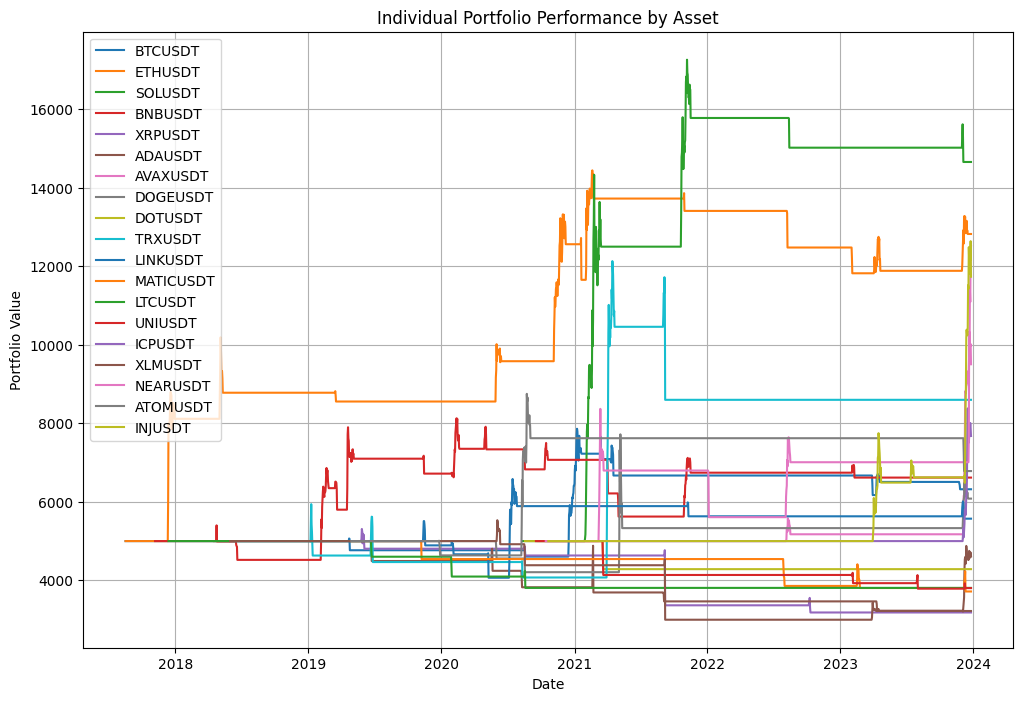

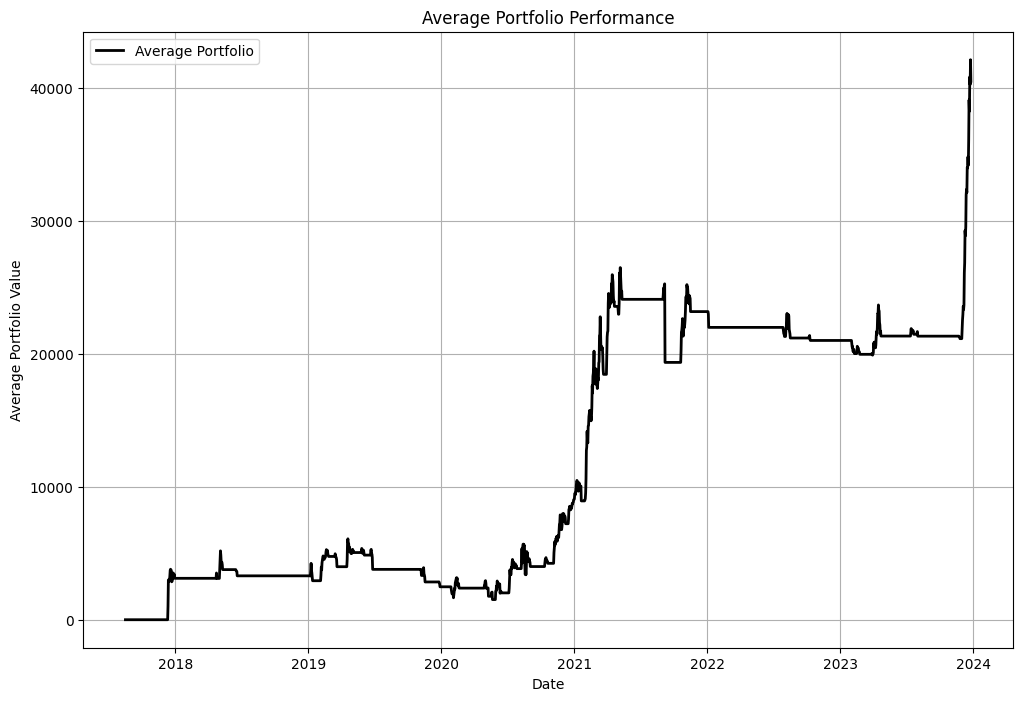

In [103]:
closed_trades, open_trades = strategy_backtest(data_dict, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
all_portfolios = describe_backtest(data_dict, closed_trades, open_trades, float(portfolio_value / len(data_dict)))

In [104]:
closed_trades

,Asset,Entry Date,Exit Date,Entry Price,Exit Price,Dollar Return,Outcome
8,ETHUSDT,2017-12-11 19:00:00,2017-12-29 19:00:00,515.00000,681.06000,2096.276746,Trail
24,BNBUSDT,2018-04-23 20:00:00,2018-04-24 20:00:00,13.97010,13.60960,-409.819537,Stop Loss
9,ETHUSDT,2018-05-02 20:00:00,2018-05-10 20:00:00,712.99000,685.39000,-86.992933,Stop Loss
25,BNBUSDT,2018-06-16 20:00:00,2018-06-19 20:00:00,16.90600,15.69510,-378.536350,Stop Loss
54,TRXUSDT,2019-01-06 19:00:00,2019-01-12 19:00:00,0.02339,0.02224,-357.293589,Stop Loss
...,...,...,...,...,...,...,...
64,LINKUSDT,2023-12-01 19:00:00,2023-12-06 19:00:00,15.39300,14.91900,-279.365758,Stop Loss
52,DOGEUSDT,2023-12-03 19:00:00,2023-12-17 19:00:00,0.08760,0.09213,491.131674,Trail
85,ATOMUSDT,2023-12-05 19:00:00,2023-12-06 19:00:00,10.22300,9.70000,-480.390619,Stop Loss
68,MATICUSDT,2023-12-07 19:00:00,2023-12-10 19:00:00,0.86720,0.84180,-257.528665,Stop Loss
